Import modules


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from scipy.signal import freqz, deconvolve, convolve

Loading training and testing data

In [18]:
def q15_to_lsf(x):
    return x.astype('float') * 2 / np.power(2, 15)

X = q15_to_lsf(np.load('./data/train/line_spectrum_frequency_low_band_speech.npy'))
y = q15_to_lsf(np.load('./data/train/line_spectrum_frequency_high_band_speech.npy'))

X_test = q15_to_lsf(np.load('./data/test/line_spectrum_frequency_low_band_speech.npy'))
y_test = q15_to_lsf(np.load('./data/test/line_spectrum_frequency_high_band_speech.npy'))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

(400952, 10)
(400952, 6)
(44551, 10)
(44551, 6)
(1386, 10)
(1386, 6)
[0.11370633 0.15138473 0.25157285 0.57322945 0.64647703 0.73007898
 0.89037997 0.95624527 1.27675138 1.36466766]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


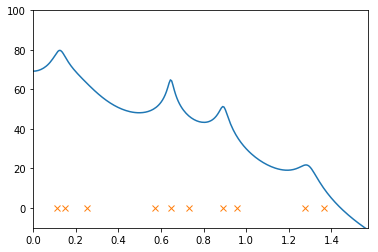

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

num_train_data = X_train.shape[0]

def lsf2poly(L):
    order = len(L)
    Q = L[::2]
    P = L[1::2]
    poles_P = np.r_[np.exp(1j*P),np.exp(-1j*P)]
    poles_Q = np.r_[np.exp(1j*Q),np.exp(-1j*Q)]
    
    P = np.poly(poles_P)
    Q = np.poly(poles_Q)
    
    P = convolve(P, np.array([1.0, -1.0]))
    Q = convolve(Q, np.array([1.0, 1.0]))
    
    a = 0.5*(P+Q)
    return a[:-1]

tmp = X_train[2,:] * np.pi/2
print(tmp)
tmp2 = np.zeros_like(tmp)
print(tmp2)
a = lsf2poly(tmp )
w, h = freqz(1.0, a)
plt.plot(w, 20 * np.log10(abs(h)))
plt.plot(tmp, tmp2, 'x')
plt.axis([0, np.pi/2, -10, 100])
plt.show()


In [10]:
def train_validate(learner, sample_size, X_train, y_train, X_valid, y_valid):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_valid: features validating set
       - y_valid: income validating set
    '''
    sample_size = int(sample_size)

    print(sample_size)
    
    results = {}

    start = time() # Get start time
    X_train = X_train[:sample_size, :]
    y_train = y_train[:sample_size, :]
    
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    print('training_done!')

    results['train_time'] = end - start

    start = time() # Get start time
    predictions_valid = learner.predict(X_valid)
    
    print('validating_done!')
    
    print(predictions_valid.shape)
    predictions_train = learner.predict(X_train[:1000, :])
    print(predictions_train.shape)
    end = time() # Get end time

    # Calculate the total prediction time
    results['pred_time'] = end - start

    print(np.argwhere(np.isnan(predictions_train)))
    print(np.argwhere(np.isnan(predictions_valid)))
    
    print(predictions_train)
    print(predictions_valid)
    
    # Compute accuracy on the first 3000 training samples
    # results['error_train'] = mean_squared_error(y_train[:1000, :], predictions_train, multioutput='raw_values')

    # Compute accuracy on validation set
    # results['error_valid'] = mean_squared_error(y_valid, predictions_valid, multioutput='raw_values')

    # TODO: Compute F-score on the the first 300 training samples
    # results['r2_train'] = r2_score(y_train, predictions_train)

    # TODO: Compute F-score on the test set
    # results['r2_valid'] = r2_score(y_valid, predictions_valid)

    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))

    # Return the results
    return results

In [11]:
clf_benchmark_1 = LinearRegression(n_jobs=-1)
# clf_benchmark_2 = DecisionTreeRegressor()
# clf_benchmark_3 = RandomForestRegressor(random_state=0, n_jobs=-1)

In [12]:
samples_1 = num_train_data // 100
samples_10 = num_train_data // 100
samples_100 = num_train_data // 100

results = {}
# for clf in [clf_benchmark_1, clf_benchmark_2, clf_benchmark_3]:
for clf in [clf_benchmark_1]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        print(i)
        results[clf_name][i] = train_validate(clf, samples, X_train, y_train, X_valid, y_valid)
    

0
4009
training_done!
validating_done!
(44551, 6)
(1000, 6)
[]
[]
[[ 0.07688508  0.22310719  0.27592912  0.44059481  0.63973824  0.87454412]
 [ 0.13801013  0.37525618  0.6276015   0.84917278  0.85853856  0.87852181]
 [ 0.14019888  0.25876179  0.33296136  0.44363236  0.66923265  0.85093462]
 ...
 [ 0.21002874  0.33578709  0.47074146  0.5450115   0.75959078  0.83550571]
 [-0.11878252  0.05985681 -0.00301376  0.29885922  0.47595893  0.96033871]
 [ 0.00282782  0.2540909   0.41301157  0.71178518  0.73217717  0.91940991]]
[[ 0.1135722   0.30456416  0.49091697  0.68126301  0.76676364  0.89241043]
 [ 0.45878563  0.58311537  0.94033988  0.87962946  1.04276056  0.76289342]
 [ 0.47216906  0.65606796  1.08595447  1.07304507  1.14555505  0.75948128]
 ...
 [ 0.10645698  0.28738018  0.42147669  0.60163537  0.73137378  0.87377271]
 [ 0.13356103  0.32028028  0.48395541  0.65461093  0.77528251  0.87311735]
 [-0.00361528  0.16770777  0.24950808  0.4874576   0.60781242  0.92389676]]
LinearRegression train

In [9]:
print results

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(results)? (<ipython-input-9-60edbf48a961>, line 1)